# Wstęp do uczenia maszynowego - Projekt 1
## Aleksander Malinowski | Damian Skowroński
___
### Milestone 2
Będziemy robić modele na danych, na których wykonaliśmy preprocessing w kamieniu milowym 1. W preprocessingu wykonaliśmy następujące zmiany:

*   dodatnie kolumn:
    *   _black_king_dst_ - odleglość czarnego króla od brzegu planszy
    *   _black2white_king_dst_ - odległość króli od siebie 
    *   _black2rook_dst_ - odległość czarnego króla od białej wieży
*   wykonanie label encoding dla zmiennych określających _file_
*   zamienienie wartości słownych w zmiennej celu _result_ na odpowiadające im liczby i wartości "draw" na "-1"

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
import warnings
from google.colab import drive
warnings.filterwarnings('ignore')

# df = pd.read_csv("training_set.csv", index_col=0).reset_index(drop=True)
drive.mount('/content/drive')
df = pd.read_csv('./drive/MyDrive/WUM_Proj1/training_set.csv', index_col=0).reset_index(drop=True)

df.head()

Mounted at /content/drive


,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result,black_king_dst,black2white_king_dst,black2rook_dst
0,2,2,3,3,8,3,13,0,6,5
1,1,1,6,3,5,3,-1,2,4,1
2,4,4,7,5,8,2,6,0,4,3
3,3,1,7,3,2,7,13,1,6,5
4,4,1,2,5,8,5,13,0,4,6


Podział na zbiór treningowy i walidacyjny

Podchodzimy do problemu przewidzenia rezultatu w następujący sposób:

1. własna klasyfikacja - uznaliśmy, że kilka wartości możemy przewidzieć sami. Zależy nam na dobrym sklasyfikowaniu remisów, które są problematyczne w regresjii.
2. model regresji w celu przewidzenia ilości ruchów, dla wyników, które w pierwszym kroku zostały sklasyfikowane
3. model klasyfikacji, żeby sprawdzić czy może sobie lepiej radzi niż regresja

### 1. Własna klasyfikacja 

#### Remisy
Remisy nam bardzo przeszkadzają w dalszej regresji więc postaramy się je przewidzieć w inny sposób i całkowicie je pominąć przy regresji.

Ponieważ zbiór danych teoretycznie przedstawia optymalne ruchy, a przewaga białego nad czarnym jest duża, remis zachodzi zapewne w jednej z dwóch sytuacji:
    1. czarny bije białą wieżę
    2. stalemate - czarny nie ma gdzie się ruszyć
    
    
##### 1. Czarny bije białą wieżę 
Taka sytuacja zdaży się w momencie, gdy czarny król jest w odległości od białej wieży równej "1", a biały król jest w odległości od białej wieży większej niż "1". W tym celu tworzymy nową zmienną _white2rook_dst_, której nie braliśmy pod uwagę w preprocessingu (możliwe, że przyda się też potem w regresji).

In [2]:
def white2rookdistance(df):
     # dystans pomiędzy białym królem i wieżą
    return max(abs(df['white_king_file'] - df['white_rook_file']),abs(df['white_king_rank'] - df['white_rook_rank']))

Następnie ze otrzymanej nowej zmiennej _white2rook_dst_ i wcześniejszej _black2rook_dst_ mogę dowiedzieć się czy czarny zbije wieżę.

In [3]:
def w2r_rt(df): 
    #white to rook distance + rook taken
    df['white2rook_dst'] = df.apply(lambda x: white2rookdistance(x), axis = 1)
    df["rook_taken"] = np.where(
        (df.black2rook_dst == 1) & (df.white2rook_dst != 1),
        1,0)
    return df

df = w2r_rt(df)

In [4]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df.rook_taken,df.result.apply(lambda x: 1 if x == -1 else 0))

array([[17682,     5],
       [    0,  1952]])

Okazuje się, nowa zmienna prawie dokładnie opisuje sytuacje i popełniła tylko kilka błędów, gdy nie znajduje remisu.



##### 2. Stalemate
W tym przypadku wystąpi w następujących sytuacjach:

![pat1.jpg](attachment:pat1.jpg)

Pierwsza sytuacja wystąpi jeśli wieża jest w dowolnym miejsu oprócz w kolumnie "a" w drugim rzędzie. Również w takiej samej sytuacji, ale dla lustrzanego odbicia wzdłuż diagonali idącej z lewego dolnego rogu do prawego górnego. Oczywiście też podobnie dla każdego rogu. 

Inaczej mówiąc jest to sytuacja, gdy jednocześnie:

* czarny król jest na granicy planszy, 
* biały król jest w tym samym rzędzie/kolumnie co czarny król
* odległość króli między sobą wynosi $2$
* biała wieża jest przesunięta o odpowiednio jeden rząd/kolumnę od granicy planszy
* biała wieża nie jest w tej samej kolumnie/rzędzie co czarny król, żeby nie mógł jej zbić (ta sytuacja i tak jest remisem, więc nie trzeba tego warunku brać pod uwagę)
  

![pat3.jpg](attachment:pat3.jpg)

Druga sytuacja wystąpi tylko po 5 razy (w czym 2 znich pokrywają się z pierwszą sytuacją) w każdym rogu. Bo biały król może być na jednym z pięciu możliwych pól obok wieży.

Dzieje się to przy następujących warunkach:

* czarny król jest w samym rogu
* biała wieża jest na diagonali oddalona od czarnego króla o 1
* biały król musi być przy białej wieży (nie jest to ważny warunek, bo jeśli nie jest przy niej to i tak jest remis i wcześniej bierzemy to pod uwagę)

In [5]:
def drawed(df):    
    df["is_draw"] = np.where(
        ((df.black2rook_dst == 1) & (df.white2rook_dst != 1)) |      # czarny bije wieze
        ((df.black_king_dst == 0) & (((np.abs(df.black_king_file - df.black_king_rank)) == 0) |  ((np.abs(df.black_king_file - df.black_king_rank)) == 7)) & (df.black2white_king_dst == 2) & (((df.white_king_file == df.black_king_file) & (np.abs(df.white_rook_file - df.black_king_file) == 1)) | ((df.white_king_rank == df.black_king_rank) & (np.abs(df.white_rook_rank - df.black_king_rank) == 1)))) |  # pierwsza sytuacja
        ((df.black_king_dst == 0) & (df.black2rook_dst == 1) & (((np.abs(df.black_king_file - df.black_king_rank)) == 0) |  ((np.abs(df.black_king_file - df.black_king_rank)) == 7)) & (((np.abs(df.white_rook_file - df.white_rook_rank)) == 0) |  ((np.abs(df.white_rook_file - df.white_rook_rank)) == 7))), # druga sytuacja
        1,0) 
    return df
df = drawed(df)

In [6]:
confusion_matrix(df.is_draw,df.result.apply(lambda x: 1 if x == -1 else 0))

array([[17682,     0],
       [    0,  1957]])

W ten sposób możemy przewidzieć każdy ramis/nieremis prawidłowo.

#### 0 ruchów do mata 
Wydaje się że można też jednoznacznie powiedzieć, kiedy mat już jest, czyli w zmiennej result jest wartość $0$. Sytuacja wygląda tak:

![mat0.jpg](attachment:mat0.jpg)

lub rzadziej tak:

![mat2.jpg](attachment:mat2.jpg)

Inaczej można powiedzieć, że jednocześnie:

* czarny król jest na krawędzi planszy
* odległość między królami jest równa 2
* wieża nie jest zbijana (nie ma remisu)
* wieża jest w tej samej kolumnie/rzędzie co czarny król
* biały król jest odpowiednio w tym samym rzędzie/kolunie co czarny król


In [7]:
def mated(df):
    df["is_mated"] = np.where(
        (df.black_king_dst == 0) & (df.black2white_king_dst == 2) & (df.is_draw == 0) & ((((df.black_king_file == df.white_rook_file) & (df.black_king_rank == df.white_king_rank) & ((df.black_king_file == 1) | (df.black_king_file == 7)))) | ((df.black_king_rank == df.white_rook_rank) & (df.black_king_file == df.white_king_file) & ((df.black_king_rank == 1) | (df.black_king_rank == 7)))) |
        (df.black_king_dst == 0) & (df.black2white_king_dst == 2) & (df.is_draw == 0) & (((np.abs(df.black_king_file - df.black_king_rank)) == 0) |  ((np.abs(df.black_king_file - df.black_king_rank)) == 7)) & ((((df.black_king_file == df.white_rook_file) & (np.abs(df.black_king_rank - df.white_king_rank) == 1) & ((df.black_king_file == 1) | (df.black_king_file == 7)))) | ((df.black_king_rank == df.white_rook_rank) & (np.abs(df.black_king_file - df.white_king_file) == 1) & ((df.black_king_rank == 1) | (df.black_king_rank == 7)))),
        1,0)
    return df

df = mated(df)    

In [8]:
confusion_matrix(df.is_mated,df.result.apply(lambda x: 1 if x == 0 else 0))

array([[19620,     0],
       [    0,    19]])

Macierz mówi, że wyłapaliśmy wszystkie przypadki bez błędów.

### 1 ruch do mata
Można też przewidzieć kiedy zostanie jeden ruch do mata jednak jest to bardziej skomplikowana sytuacja. Poniższy kod będzie działać tylko na tym zbiorze, w którym biały król jest ograniczony do pól w trójkącie w rogu planszy. 

In [9]:
def mated_in1(df):
    df["is_mated1"] = np.where(
        (df.black_king_dst == 0) & (df.rook_taken ==0) & (df.is_mated ==0) & (df.is_draw == 0) & (
            ((df.black_king_rank == 1) & (df.black_king_file == 1) & (df.white_king_file == 3) & (df.white_king_rank == 2) & (df.white_rook_file >= 2) & (df.white_rook_rank > 3)) |
            ((df.white_rook_file == 1) &  (df.black_king_file == 2) & (df.white_king_file == 3) & (df.white_king_rank == 3)) |
            ((df.black_king_file == 1) & (df.black_king_rank == 3) & (df.white_rook_rank == 4) & (df.white_king_file == 3) & (df.white_king_rank == 2)) |
            ((df.black_king_file == 1) & (df.black_king_rank == 2) & (df.white_rook_rank == 3) & (df.white_king_file == 3) & (df.white_king_rank == 1)) |
            ((df.black_king_file == 5) & (df.black_king_rank == 1) & (df.white_rook_file == 6) & (df.white_king_file == 4) & (df.white_king_rank == 3)) |
            ((df.black_king_file == 4) & (df.black_king_rank == 1) & (df.white_rook_file == 5) & (df.white_king_file == 3) & (df.white_king_rank == 3)) |
            ((df.black_king_file == 3) & (df.black_king_rank == 1) & (df.white_rook_file == 2) & (df.white_king_file == 4) & (df.white_king_rank == 3)) |
            ((df.black_king_file == 1) & (df.black_king_rank == 2) & (df.white_rook_rank == 3) & (df.white_king_file == 3) & (df.white_king_rank == 2))
        ),
        1,0
    )
    return df
df_test = mated_in1(df)

In [10]:
confusion_matrix(df_test.is_mated1, df.result.apply(lambda x: 1 if x == 1 else 0))

array([[19584,     0],
       [    0,    55]])

Znowu udało nam się wyłapać wszystkie takie sytuacje 

W Możliwe, że jeszcze można zrobić tak dla innych sytuacji, jednak im więcej ruchów tym bardziej skomplikowana sytuacja - więcej możliwości - więcej warunków.

### 2. Regresja
Regresję wykonujemy w celu dowiedzenia się ile ruchów będzie potrzebne do zamatowania. Wykonywać ją będziemy na części obserwacji, które w poprzednim kroku nie zostały już przewidziane.


In [11]:
def drop_predicted(df):
    # do regresji zostawiamy tylko te wiersze, których nie przewidzieliśmy
    # na początku sortujemy w ten spoosb, aby remisy były na początku, a potem maty, żeby potem łatwiej połączyć ramkę, i nie musiec pamietac o indexach
    df_sorted = df.sort_values(by = ["is_draw","is_mated","is_mated1"], ascending= False).reset_index(drop=True) 
    df_draws = df_sorted.drop(index=np.where(df_sorted.is_draw != 1)[0])
    df_mates = df_sorted.drop(index=np.where(df_sorted.is_mated != 1)[0])
    df_mates1 = df_sorted.drop(index=np.where(df_sorted.is_mated1 != 1)[0])
    df_sorted_dropped = df_sorted.drop(index=np.where(((df_sorted.is_draw == 1) | (df_sorted.is_mated == 1) | (df_sorted.is_mated1 == 1)))[0])
    return df_draws, df_mates, df_mates1, df_sorted_dropped

df_draws, df_mates, df_mates1, df_sorted_dropped = drop_predicted(df)

Dalej podzielimy zbiór przeznaczony dla modeli.

In [12]:
train_X, test_X, train_y, test_y = train_test_split(df_sorted_dropped.drop(columns = ["result"]), df_sorted_dropped.result, 
                                                    test_size = 0.3, random_state= 420, stratify=df_sorted_dropped.result)

I poszukamy modelu, który będzie dobrze przewidywał:


#### 1. SVM

In [13]:
from sklearn import svm
regr = svm.SVR()
regr.fit(train_X,train_y)
regr.score(test_X,test_y)

0.7981067817883893

In [14]:
svr_rbf = svm.SVR(kernel="rbf", C=10, gamma=0.1, epsilon=0.1)
svr_lin = svm.SVR(kernel="linear", C=10, gamma="auto")
svr_poly = svm.SVR(kernel="poly", C=10, gamma="auto", degree=2, epsilon=0.1, coef0=1)


In [15]:
svr_rbf.fit(train_X,train_y)
svr_rbf.score(test_X,test_y)

0.8975938899999409

In [16]:
svr_lin.fit(train_X,train_y)
svr_lin.score(test_X,test_y)

0.6273387393556048

In [17]:
svr_poly.fit(train_X,train_y)
svr_poly.score(test_X,test_y)

0.7833716902138717

Najlepiej spisał się model z kernelem "rbf".

#### 2. Regresja liniowa 

In [20]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_X,train_y)
lr.score(test_X,test_y)

0.6495057498998563

#### 3. Lasso

In [21]:
from sklearn.linear_model import Lasso
las = Lasso(alpha=0.1)
las.fit(train_X,train_y)
las.score(test_X,test_y)

0.6430111511897658

#### 4. Kernel Ridge

In [22]:
from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(alpha=0.1)
krr.fit(train_X,train_y)
krr.score(test_X,test_y)

0.43737671261058864

#### Wnioski
Wygląda na to, że zdecydowanie najlepiej spisuje się SVM z kernelem "rbf". Wobec tego zajmiemy się znalezieniem odpowiednich hiperparametrów używająć opytmalizacji bayesowskiej. (random search i grid search nie sprawdziły sie dobrze)

In [23]:
# from skopt import BayesSearchCV
# from skopt.space import Integer, Real

# #przykladowe
# model = svm.SVR(kernel="rbf")
# bayes = BayesSearchCV(model,search_spaces={
#     "C" : Integer(20,100),
#     "degree" : Integer(1,10),
#     "gamma" : Real(0,1),
#     "epsilon": Real(0,1)
# },n_jobs=-1,cv = 5)

# bayes.fit(train_X,train_y)

Użyliśmy optymalizacji bayesowskiej kilka razy na różne sposoby i otrzymaliśmy różne rezultaty jeśli chodzi o hiperparametry, lecz podobne wyniki score. Wobec tego wydaje się, że hiperparametry, oprócz "kernel", w tym przypadku nie mają dużego znaczenia.

In [24]:
bayes1 = svm.SVR(kernel = 'rbf',C=41, degree=2, epsilon=0.5453896028447068, gamma=0.29095860195816414)
bayes2 = svm.SVR(kernel = 'rbf',C=30, degree=5, epsilon=0.1967759806539503, gamma=0.08869823764675565)
bayes3 = svm.SVR(kernel = 'rbf',C=20, degree=1, epsilon=0.2010835792844748, gamma=0.09924388919619698)

In [25]:
bayes1.fit(train_X,train_y)
bayes2.fit(train_X,train_y)
bayes3.fit(train_X,train_y)

SVR(C=20, degree=1, epsilon=0.2010835792844748, gamma=0.09924388919619698)

Osiągają one na części testowej następujące wyniki: 

In [26]:
print("bayes1:",bayes1.score(test_X,test_y),
      "\nbayes2:",bayes2.score(test_X,test_y),
      "\nbayes3:",bayes3.score(test_X,test_y),
      "\nsvr_rbf (sprawdzany wcześniej):", svr_rbf.score(test_X,test_y))

bayes1: 0.8876647802215499 
bayes2: 0.898440593929465 
bayes3: 0.8989734607619826 
svr_rbf (sprawdzany wcześniej): 0.8975938899999409


Widać, że trzy ostatnie sobie dobrze radzą i są między nimi nieznaczne różnice.

In [27]:
from sklearn.ensemble import VotingRegressor

vr = VotingRegressor(estimators=[('b2', bayes2), ('b3', bayes3), ('def', svr_rbf)],
                       n_jobs = -1)
vr.fit(train_X,train_y)
vr.score(test_X,test_y)

0.8993261943565812

In [28]:
from sklearn.ensemble import BaggingRegressor

br_r = BaggingRegressor(base_estimator=bayes2,n_jobs = -1)
br_r.fit(train_X,train_y)
br_r.score(test_X,test_y)

0.901683426011285

Ensablingi też dużo nie zmieniły, chociaż BaggingRegressor pozwolił otrzymać najlepszy do tej pory wynik. Wobec tego ostatecznie będzie wykorzystywany.

###  3. Klasyfikacja

Poszukamy teraz dobrego modelu klasyfikacyjnego, który może okazać się lepszy od modelu regresyjnego.

In [29]:
# korzystamy z google collaba więc trzeba za każdym razem installować
!pip install scikit-plot
!pip install catboost
!pip install eli5

     |████████████████████████████████| 76.6 MB 96 kB/s 
     |████████████████████████████████| 106 kB 4.4 MB/s 


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

import matplotlib.pyplot as plt
metrics = {
    'accuracy': accuracy_score,
    'recall': recall_score,
    'precision': precision_score,
    'f1_score': f1_score,
    'roc_auc': roc_auc_score,
}

models = {
    'LGR': LogisticRegression(solver = 'lbfgs', random_state=42, verbose=0),
    'DTC': DecisionTreeClassifier(random_state=42),
    'RFC': RandomForestClassifier(random_state=42),
    'ETC': ExtraTreesClassifier(random_state=42),
    'XGB': xgb.XGBClassifier(random_state=42),
    'LGBM': lgb.LGBMClassifier(random_state=42),
    'CTB': ctb.CatBoostClassifier(verbose=0),
}


for model in models.items():
    print(model[0])
    model[1].fit(train_X,train_y)
    print(model[1].score(test_X,test_y))

LGR
0.38576566344879804
DTC
0.7876206700738216
RFC
0.6916524701873935
ETC
0.6295665341661935
XGB
0.5110732538330494
LGBM
0.7293204618587924
CTB
0.7741813363619156


Najlepiej wyszedł nam model DecisionTreeClassifier, zrobimy dla niego optymalizację hiperparametrów.

In [ ]:
# model = models['DTC']
# from sklearn.model_selection import GridSearchCV
# min_split_space = np.arange(1, 10)
# min_leaf_space = np.arange(1, 10)
# space ={
#         'criterion': ['gini', 'entropy'],
#         'splitter': ['best','random'],
#         'min_samples_split': min_split_space,
#         'min_samples_leaf': min_leaf_space,
#         'min_impurity_decrease' : np.arange(0,2,10),
#         'ccp_alpha' : np.arange(0,2,10)
#     }
# g_cv = GridSearchCV(model,space)
# g_cv.fit(df_sorted_dropped.drop(columns = ["result"]), df_sorted_dropped.result)
# print("Tuned Parameter: {}".format(g_cv.best_params_))
# print("Tuned Accuracy: {}".format(g_cv.best_score_))

Tuned Parameter: {'ccp_alpha': 0, 'criterion': 'entropy', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Tuned Accuracy: 0.7962413760053646


Ostatecznie z klasyfikacji mamy:

In [31]:
dfc_model = DecisionTreeClassifier(ccp_alpha = 0, criterion = 'entropy', min_impurity_decrease = 0, min_samples_leaf = 1, min_samples_split = 2, splitter = 'best')
dfc_model.fit(train_X,train_y)
dfc_model.score(test_X,test_y)

0.7847813742191937

Wykonamy teraz ensembling

In [32]:
from sklearn.ensemble import VotingClassifier

vr = VotingClassifier(estimators=[('entropy', DecisionTreeClassifier(criterion='entropy',random_state=42)), ('def', DecisionTreeClassifier(random_state=42))],
                       n_jobs = -1)
vr.fit(train_X,train_y)
vr.score(test_X,test_y)

0.7817527919742571

In [33]:
from sklearn.ensemble import BaggingClassifier

br_c = BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',random_state=42),n_jobs = -1)
br_c.fit(train_X,train_y)
br_c.score(test_X,test_y)

0.8010600037857278

## Wyniki

Zgarniając naszą ramkę danych w całość (to znaczy z powrotem łącząc remisy z resztą), otrzymamy ostateczny wynik score naszego modelu.

In [ ]:
def get_predictions_fulldf(df_draws,df_mates,df_mates1,df_sorted_dropped,estimator):
    
    regr_pred = estimator.predict(df_sorted_dropped.drop(columns="result"))
    draws = np.ones(df_draws.shape[0])*-1 #-1 oznaczało u nas wcześniej draw
    mates = np.zeros(df_mates.shape[0])
    mates1 = np.ones(df_mates1.shape[0])
    prediction = np.concatenate((draws,mates,mates1,regr_pred))
    df_concat = pd.concat([df_draws,df_mates,df_mates1,df_sorted_dropped])
    return df_concat,prediction

df_concat_r,prediction_r = get_predictions_fulldf(df_draws,df_mates,df_mates1,df_sorted_dropped,br_r)
df_concat_c,prediction_c = get_predictions_fulldf(df_draws,df_mates,df_mates1,df_sorted_dropped,br_c)


In [38]:
# source kodu: https://saptarshidatta.in/2020/10/05/PyTorch_CIFAR10.html
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


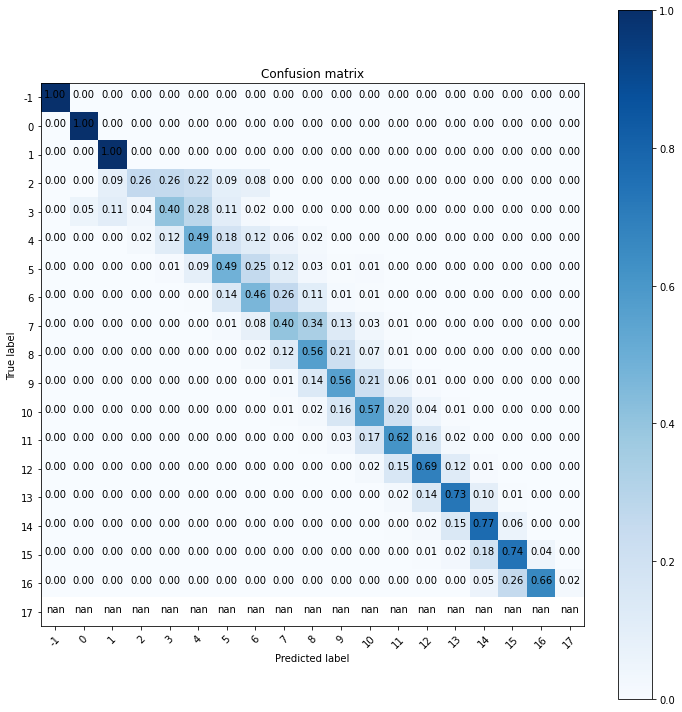

In [39]:
cm = confusion_matrix(df_concat_r.result, np.round(prediction_r))
classes = range(-1,18)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes,title='Confusion matrix')

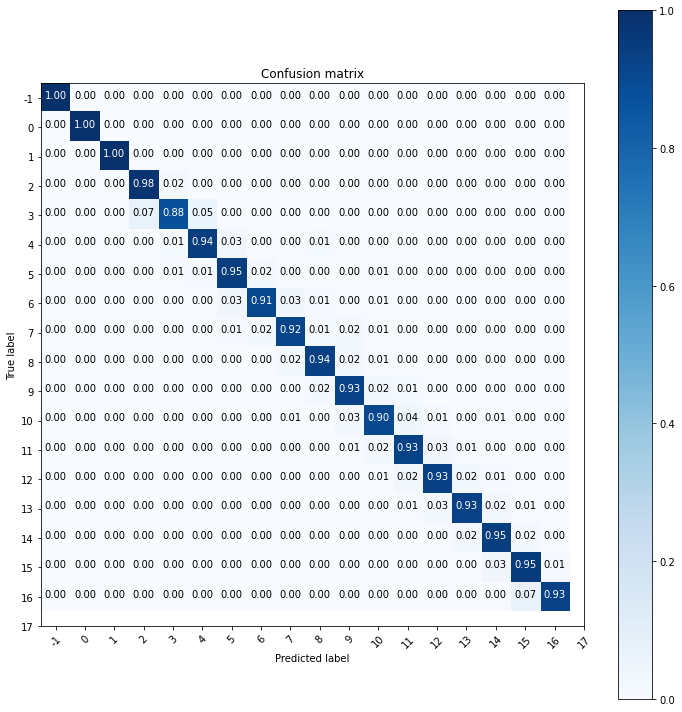

In [40]:
cm = confusion_matrix(df_concat_c.result, np.round(prediction_c))
classes = range(-1,18)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes,title='Confusion matrix')

## Podsumowanie (nie jest ogarniete)
*   Użyliśmy na zbiorze funkcji **w2r_rt**, która dodała dwie nowe kolumny, informujące o odległości białego króla od białej wieży, a także o tym czy wieża zostanie zbita.
*   Ufało nam się z całkowitą pewnością przewidzieć remisy i maty funkcjami **drawed** i **mated**. Wyniki są w kolumnach odpowiednio *is_draw* i *is_mated*.
*   Użyliśmy funkcji **drop_predicted_draws** do rozdzielenia zbioru, na dwa: 
    *   *df_draws* - zbiór, w którym ustalamy, że są same remisy
    *   *df_mates* - zbiór, w którym ustalamy, że jest już zamatowane
    *   *df_sorted_dropped* - zbiór, w którym przewidujemy, że nie będzie remisu, ani mata, i będziemy wykonywać dalszą predykcję
*   Sprawdziliśmy kilka modeli regresji w celu ustalenia liczby ruchów potrzebnych do mata. Ostatecznie najlepiej sprawdziły się modele SVM o hiperparametrze kernel = "rbf"
*   Przeprowadziliśmy optymalizację bayesowską, która znalazła troche lepsze parametry, ale nie zrobiło to większej różnicy.
*   Spróbowaliśmy ensemblingu, i wyszło, że _BaggingReggressor_ (nazwa zmiennej - **br**) używający naszego estymatora spisuje się nieco lepiej niż dotychczasowe modele
*   Używając funkcji **get_prediction_fulldf** łączymy rozdzielone wcześniej ramki danych i predykcje, a następnie liczymy ich score. 
